# Bayesian Inference with PyMC - Allen Downey
+ [Notebooks](https://allendowney.github.io/BayesianInferencePyMC/index.html)
+ [Slides](https://docs.google.com/presentation/d/e/2PACX-1vRfzvjPnyBevd1VBt8yxwP23xuddrcYgu1mYOsTE9o_ViWJqoxWMhzgcw-FPhfeeobEbXYoeJvsPuQ-/pub#slide=id.p)

In [1]:
import sys
import os
from pathlib import Path 

import pandas as pd
import numpy as np
import arviz as az
import pymc3 as pm
import xarray as xr
import theano.tensor as tt
import bambi as bmb
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import plotnine as p9

%load_ext dotenv
%dotenv
PROJECT_DIR=Path(os.environ.get('PROJECT_DIR'))
sys.path.append(str(PROJECT_DIR))

DATA_DIR = PROJECT_DIR / 'scratchpads'  / 'data'
DATA_DIR

PosixPath('/media/david/T7/code/bmcp/bmcp-notes/scratchpads/data')

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

theme_set(theme_bw())
pd.set_option('display.max_columns', 100)
xr.set_options(display_expand_data=False, display_expand_attrs=False, display_expand_coords=False,
              display_expand_data_vars=False)
SEED = 1925

%load_ext watermark
%watermark --iversions

arviz     : 0.11.2
bambi     : 0.6.3
matplotlib: 3.4.3
pymc3     : 3.11.4
xarray    : 0.19.0
seaborn   : 0.11.2
plotnine  : 0.8.0
theano    : 1.1.2
pandas    : 1.3.2
sys       : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:11) 
[GCC 9.4.0]
numpy     : 1.19.5
scipy     : 1.7.1



# Estimating Rates

## Hockey

In [3]:
mu = 2.4
sample_poisson = pm.Poisson.dist(mu).random(size=1000)
sample_poisson.mean()
sample_poisson_df = pd.DataFrame(sample_poisson, columns=['goals'])
sample_poisson_df.head()

,goals
0,6
1,2
2,2
3,0
4,3


In [4]:
print(sample_poisson_df['goals'].mean())

2.343


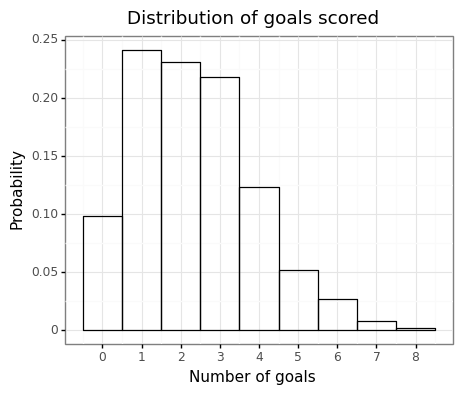

In [5]:
p = (ggplot(sample_poisson_df, aes('goals', after_stat('density')))+
     geom_histogram(bins=sample_poisson_df['goals'].max() + 1, color='black', fill='none') +
     labs(title="Distribution of goals scored", x='Number of goals', y='Probability') +
     scale_x_continuous(breaks=range(sample_poisson_df['goals'].max() + 1)) +
     theme(figure_size=(5,4))
    )
p.draw();

## Gamma Distribution
+ Use gamma distribution to model mu - the goal scoring rate

In [6]:
alpha=4.6
beta = 1.9
sample_gamma = pm.Gamma.dist(alpha, beta).random(size=1000)
sample_gamma_df = pd.DataFrame(sample_gamma, columns=['sample_gamma'])
sample_gamma_df.head()

,sample_gamma
0,1.797975
1,3.318508
2,2.070796
3,0.653249
4,2.602725


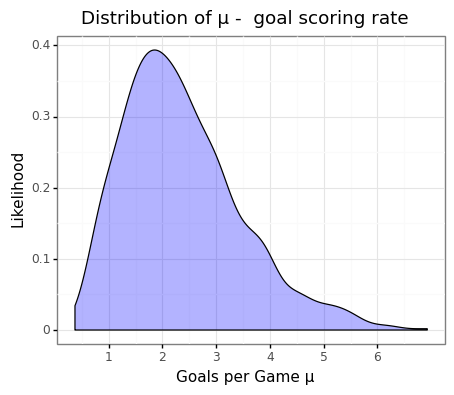

In [7]:
p = (ggplot(sample_gamma_df, aes('sample_gamma'))+
     geom_density(color='black', fill='blue', alpha=0.3) +
     labs(title="Distribution of μ -  goal scoring rate", x='Goals per Game μ', y='Likelihood') +
     scale_x_continuous(breaks=range(int(sample_gamma_df['sample_gamma'].max()) + 1)) +
     theme(figure_size=(5,4))
    )
p.draw();

## Making a Model

In [8]:
with pm.Model() as model1:
    mu = pm.Gamma('mu', alpha, beta)
    trace1 = pm.sample_prior_predictive(1000)
    idata_model1 = az.from_pymc3(prior=trace1)

In [9]:
sample_prior_df = idata_model1.prior['mu'].to_dataframe().droplevel(0).reset_index()
sample_prior_df['mu'].mean()

2.4460374180957416

In [10]:
sample_prior_df.head()

,draw,mu
0,0,3.991132
1,1,1.112034
2,2,2.033554
3,3,4.218103
4,4,3.238799


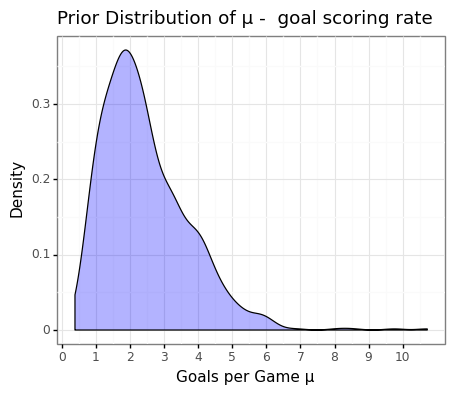

In [11]:
p = (ggplot(sample_prior_df, aes('mu'))+
     geom_density(color='black', fill='blue', alpha=0.3) +
     labs(title="Prior Distribution of μ -  goal scoring rate", x='Goals per Game μ', y='Density') +
     scale_x_continuous(breaks=range(int(sample_prior_df['mu'].max()) + 1)) +
     theme(figure_size=(5,4))
    )
p.draw();

## Adding to the Model

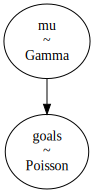

In [12]:
with pm.Model() as model2:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu)
    prior_pred = pm.sample_prior_predictive(1000)
    idata_model2 = az.from_pymc3(prior=prior_pred)
pm.model_to_graphviz(model2)

In [13]:
sample_prior_df = idata_model2.prior['goals'].to_dataframe().droplevel(0)
sample_prior_df.head()

,goals
draw,
0,2
1,3
2,4
3,0
4,1


In [14]:
sample_prior_df['goals'].mean()

2.426

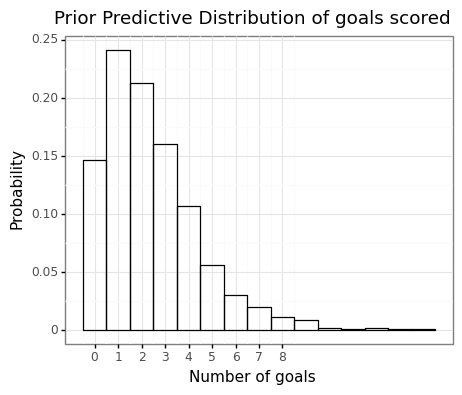

In [15]:
p = (ggplot(sample_prior_df, aes('goals', after_stat('density')))+
     geom_histogram(bins=sample_prior_df['goals'].max() + 1, color='black', fill='none') +
     labs(title="Prior Predictive Distribution of goals scored", x='Number of goals', y='Probability') +
     scale_x_continuous(breaks=range(sample_poisson_df['goals'].max() + 1)) +
     theme(figure_size=(5,4))
    )
p.draw();

+ The prior predictive distribution has 2 sources of variation
    + mu - the mean goal scoring rate is estimated by samles drawn from a gamma distribution
    + This is fed to the poisson distribution which generates more variation by sampling from a poisson distribution with each value of mu
+ Below shows the means of the actual data compared to the model are similar
+ However the variation is more in the model

In [16]:
sample_poisson_df['goals'].mean() , sample_prior_df['goals'].mean()

(2.343, 2.426)

In [17]:
sample_poisson_df['goals'].std() , sample_prior_df['goals'].std()

(1.5491128915449484, 2.056879859095994)

## When do we get to Inference?
+ Assume team A plays team B and scores 4 goals

In [18]:
with pm.Model() as model3:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=4)
    trace = pm.sample(500)
    prior = pm.sample_prior_predictive()
    idata_model3 = az.from_pymc3(prior=prior, trace=trace)    

/tmp/ipykernel_337144/1177847662.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


In [19]:
idata_model3

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [20]:
sample_prior_df = idata_model3.prior['mu'].to_dataframe()
sample_posterior_df = idata_model3.posterior['mu'].to_dataframe()
sample_posterior_df

mu
chain draw          
0     0     3.111547
      1     4.516438
      2     3.486903
      3     3.486903
      4     5.106634
...              ...
3     495   3.086553
      496   3.963280
      497   1.556608
      498   1.026953
      499   3.903060

[2000 rows x 1 columns]

In [21]:
sample_posterior_df['mu'].mean()

2.970583839230134

In [22]:
sample_prior_df

mu
chain draw          
0     0     2.824053
      1     1.243529
      2     1.925373
      3     2.315612
      4     2.166244
...              ...
      495   2.644185
      496   1.221752
      497   2.047641
      498   2.420740
      499   2.161520

[500 rows x 1 columns]

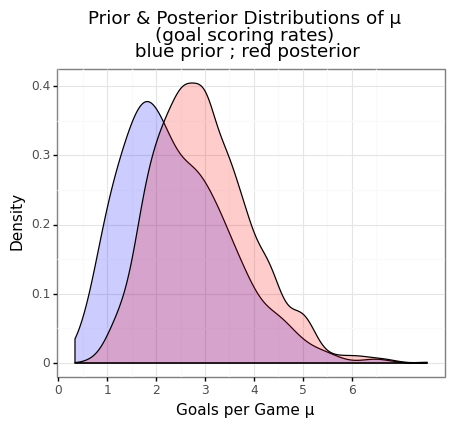

In [23]:
p = (ggplot() +
     geom_density(sample_prior_df, aes('mu'), color='black', fill='blue', alpha=0.2) +
     geom_density(sample_posterior_df, aes('mu'), color='black', fill='red', alpha=0.2) +
     labs(title="Prior & Posterior Distributions of μ\n(goal scoring rates)\n blue prior ; red posterior",
          x='Goals per Game μ', y='Density') +
     scale_x_continuous(breaks=range(int(sample_prior_df['mu'].max()) + 1)) +
     theme(figure_size=(5,4))
    )
p.draw();

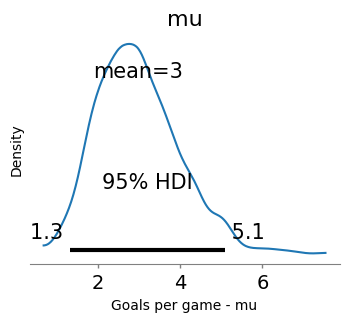

In [24]:
fig, ax = plt.subplots(figsize=(4,3))
az.plot_posterior(idata_model3, ax=ax, hdi_prob=0.95)
ax.set_ylabel('Density')
ax.set_xlabel('Goals per game - mu')
plt.show();

## Two Teams
+ Assume team A scores 5 goals and team B scores 1 goal

In [25]:
alpha = 4.6
beta = 1.9

In [26]:
with pm.Model() as model4:
    mu_A = pm.Gamma('mu_A', alpha, beta)
    mu_B = pm.Gamma('mu_B', alpha, beta)
    goals_A = pm.Poisson('goals_A', mu_A, observed=[5])
    goals_b = pm.Poisson('goals_B', mu_B, observed=[1])

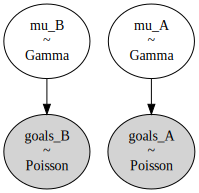

In [27]:
pm.model_to_graphviz(model4)

In [28]:
with model4:
    prior4 = pm.sample_prior_predictive()
    trace4 = pm.sample(500)
    idata_model4 = az.from_pymc3(prior=prior4, trace=trace4)

/tmp/ipykernel_337144/1049241478.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_B, mu_A]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


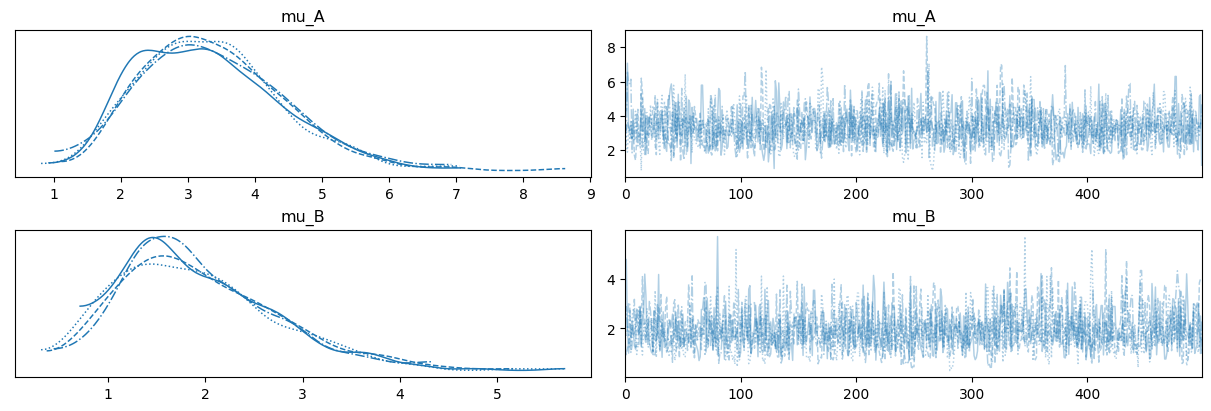

In [29]:
az.plot_trace(idata_model4);

In [30]:
mu_A_df = idata_model4.posterior['mu_A'].to_dataframe()
mu_B_df = idata_model4.posterior['mu_B'].to_dataframe()
mu_A_df['mu_A'].mean() , mu_B_df['mu_B'].mean()

(3.34963880432686, 1.9284069791520406)

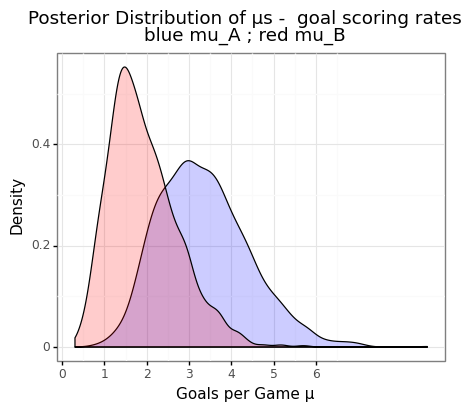

In [31]:
p = (ggplot() +
     geom_density(mu_A_df, aes('mu_A'), color='black', fill='blue', alpha=0.2) +
     geom_density(mu_B_df, aes('mu_B'), color='black', fill='red', alpha=0.2) +
     labs(title="Posterior Distribution of μs -  goal scoring rates\nblue mu_A ; red mu_B",
          x='Goals per Game μ', y='Density') +
     scale_x_continuous(breaks=range(int(sample_prior_df['mu'].max()) + 1)) +
     theme(figure_size=(5,4))
    )
p.draw();

## Probability of Superiority
+ chance that a random value from Team A posterior exceeds a random value from Team b posterior

In [32]:
(mu_A_df['mu_A'] > mu_B_df['mu_B']).mean()

0.871

## Exercise
Suppose the same teams play again and Team A wins 3-1. Modify the previous example to take into account both games. How much does the second game affect the posterior distributions and the probability of superiority?
+ First game: team A scores 5 goals and team B scores 1 goal
+ Second game: team A 3, team B 1

In [33]:
observed_A = [5, 3]
observed_B = [1, 1]

/tmp/ipykernel_337144/4079462047.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_B, mu_A]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
The acceptance probability does not match the target. It is 0.8900311951439988, but should be close to 0.8. Try to increase the number of tuning steps.


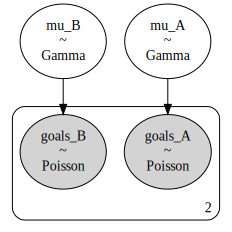

In [34]:
with pm.Model() as model5:
    
    mu_A = pm.Gamma('mu_A', alpha, beta)
    mu_B = pm.Gamma('mu_B', alpha, beta)
    
    goals_A = pm.Poisson('goals_A', mu_A, observed=observed_A)
    goals_B = pm.Poisson('goals_B', mu_B, observed=observed_B)
    
    prior5 = pm.sample_prior_predictive()
    trace5 = pm.sample()
    idata_model5 = az.from_pymc3(prior=prior5, trace=trace5)
pm.model_to_graphviz(model5)

In [35]:
idata_model5

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

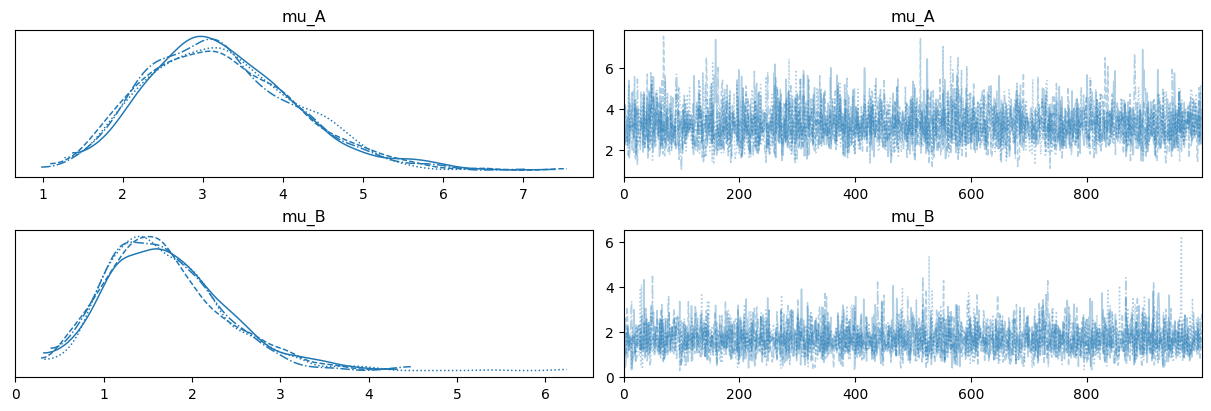

In [36]:
az.plot_trace(idata_model5);

In [37]:
mu_A_df = idata_model5.posterior['mu_A'].to_dataframe()
mu_B_df = idata_model5.posterior['mu_B'].to_dataframe()
mu_A_df['mu_A'].mean() , mu_B_df['mu_B'].mean()

(3.228475263401623, 1.685534815936981)

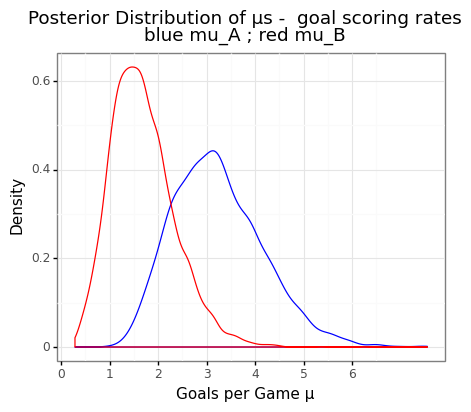

In [38]:
p = (ggplot() +
     geom_density(mu_A_df, aes('mu_A'), color='blue', fill='none', alpha=0.2) +
     geom_density(mu_B_df, aes('mu_B'), color='red', fill='none', alpha=0.2) +
     labs(title="Posterior Distribution of μs -  goal scoring rates\nblue mu_A ; red mu_B",
          x='Goals per Game μ', y='Density') +
     scale_x_continuous(breaks=range(int(sample_prior_df['mu'].max()) + 1)) +
     theme(figure_size=(5,4))
    )
p.draw();

In [39]:
(mu_A_df['mu_A'] > mu_B_df['mu_B']).mean()

0.91875

# Making Predictions

## Prediction
+ What distribution of goals should we expect if the teams play a third game

In [40]:
alpha = 4.6
beta = 1.9

In [41]:
with pm.Model() as model1:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=4)
    trace1 = pm.sample(500)
    idata_model1 = az.from_pymc3(trace=trace1)

/tmp/ipykernel_337144/4157314536.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


In [42]:
sample_posterior = idata_model1.posterior['mu'].to_dataframe().reset_index()
len(sample_posterior)

2000

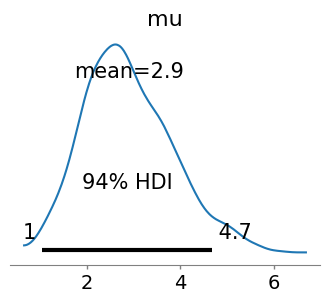

In [43]:
fig, ax = plt.subplots(figsize=(4,3))
az.plot_posterior(idata_model1.posterior['mu'], ax=ax)
plt.show();

## Posterior Predictive Distribution

In [44]:
with model1:
    post_pred = pm.sample_posterior_predictive(trace1)
    idata_model1.extend(az.from_pymc3(posterior_predictive=post_pred))

In [45]:
idata_model1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> posterior_predictive

In [46]:
sample_post_pred = idata_model1.posterior_predictive['goals'].to_dataframe().reset_index()
sample_post_pred
# sample_post_pred['goals'].mean()

,chain,draw,goals
0,0,0,2
1,0,1,7
2,0,2,3
3,0,3,3
4,0,4,6
...,...,...,...
1995,0,1995,3
1996,0,1996,2
1997,0,1997,3
1998,0,1998,4


In [47]:
sample_post_pred['goals'].mean()

2.905

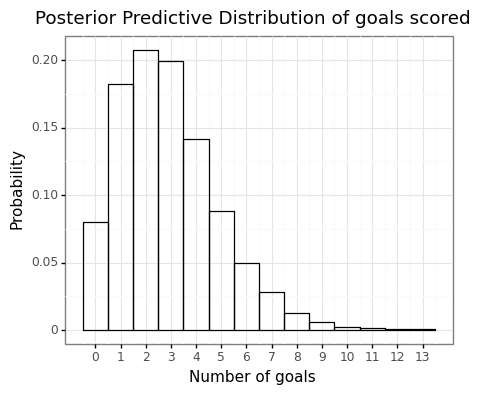

In [48]:
p = (ggplot(sample_post_pred, aes('goals', after_stat('density')))+
     geom_histogram(bins=sample_post_pred['goals'].max() + 1, color='black', fill='none') +
     labs(title="Posterior Predictive Distribution of goals scored", x='Number of goals', y='Probability') +
     scale_x_continuous(breaks=range(sample_post_pred['goals'].max() + 1)) +
     theme(figure_size=(5,4))
    )
p.draw();

## Two Teams
+ Two games are played A vs B with scores 5-1 and 3-1

In [49]:
with pm.Model() as model2:
    mu_A = pm.Gamma('mu_A', alpha, beta)
    mu_B = pm.Gamma('mu_B', alpha, beta)
    goals_A = pm.Poisson('goals_A', mu_A, observed=[5,3])
    goals_B = pm.Poisson('goals_B', mu_B, observed=[1,1])
    trace2 = pm.sample(500)
    idata_model2 = az.from_pymc3(trace=trace2)

/tmp/ipykernel_337144/3643561010.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_B, mu_A]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


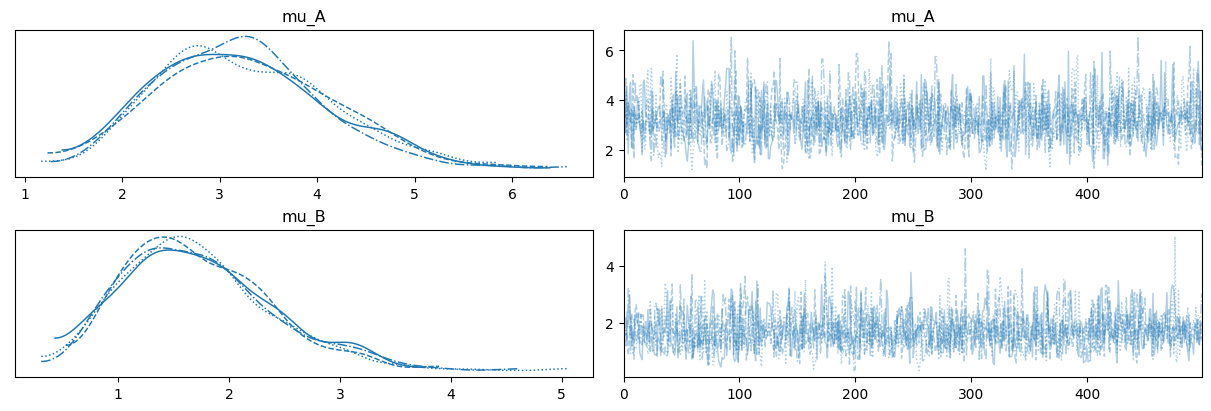

In [50]:
az.plot_trace(idata_model2)
plt.show();

In [51]:
idata_model2

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [52]:
mu_A_df = idata_model2.posterior['mu_A'].to_dataframe()
mu_B_df = idata_model2.posterior['mu_B'].to_dataframe()
mu_A_df['mu_A'].mean() , mu_B_df['mu_B'].mean()

(3.2485458854729354, 1.715184547735186)

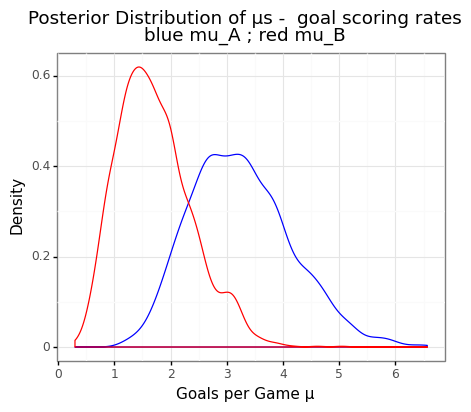

In [53]:
p = (ggplot() +
     geom_density(mu_A_df, aes('mu_A'), color='blue', fill='none', alpha=0.2) +
     geom_density(mu_B_df, aes('mu_B'), color='red', fill='none', alpha=0.2) +
     labs(title="Posterior Distribution of μs -  goal scoring rates\nblue mu_A ; red mu_B",
          x='Goals per Game μ', y='Density') +
     scale_x_continuous(breaks=range(int(sample_prior_df['mu'].max()) + 1)) +
     theme(figure_size=(5,4))
    )
p.draw();

+ Probability of superiority

In [54]:
(mu_A_df['mu_A'] > mu_B_df['mu_B']).mean()

0.928

## Predictions

In [55]:
with model2:
    post_pred = pm.sample_posterior_predictive(trace2)
    idata_model2.extend(az.from_pymc3(posterior_predictive=post_pred))

In [56]:
idata_model2

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> posterior_predictive

In [57]:
goals_A_df = idata_model2.posterior_predictive['goals_A'].to_dataframe().reset_index()[['goals_A']]
goals_B_df = idata_model2.posterior_predictive['goals_B'].to_dataframe().reset_index()[['goals_B']]
max_goals = max(goals_A_df['goals_A'].max(), goals_B_df['goals_B'].max())
print(max_goals)
goals_A_df

12


,goals_A
0,0
1,4
2,5
3,6
4,2
...,...
3995,2
3996,8
3997,3
3998,4


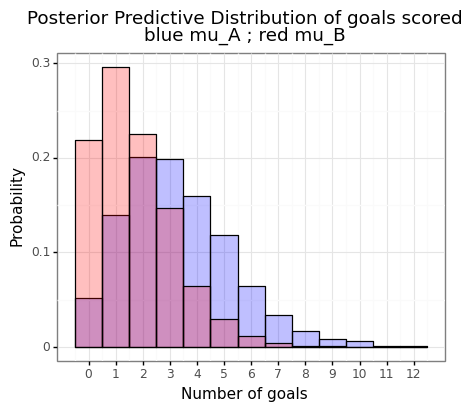

In [58]:
p = (ggplot() +
     geom_histogram(goals_A_df, aes('goals_A', after_stat('density')), bins=max_goals + 1, color='black', fill='blue', alpha=0.25) +
     geom_histogram(goals_B_df, aes('goals_B', after_stat('density')), bins=max_goals + 1, color='black', fill='red', alpha=0.25) +
     labs(title="Posterior Predictive Distribution of goals scored\nblue mu_A ; red mu_B", x='Number of goals', y='Probability') +
     scale_x_continuous(breaks=range(max_goals + 1)) +
     theme(figure_size=(5,4))
    )
p.draw();

+ Team B  more likely to score 0, 1, 2 goals
+ Team A more likely to score 3 or more
+ Chance that A wins next game

In [59]:
p_A_win = (goals_A_df['goals_A'] > goals_B_df['goals_B']).mean()
p_A_win

0.66525

In [60]:
p_A_lose = (goals_A_df['goals_A'] < goals_B_df['goals_B']).mean()
p_A_lose

0.1945

In [61]:
p_draw = (goals_A_df['goals_A'] == goals_B_df['goals_B']).mean()
p_draw

0.14025

## Sudden Death
+ In overtime, first team to score wins the game
+ For a poisson process, the time to next event is 1/mu
+ Sample from the posterior predictive distribution to for time until next goal in units of games

In [62]:
t_A = pm.Exponential.dist(mu_A_df['mu_A'].values).random(1000)
t_A.mean()

0.3426490121684694

In [63]:
t_B = pm.Exponential.dist(mu_B_df['mu_B'].values).random(1000)
t_B.mean()

0.6989944212636269

+ On average, it will take longer for team B to score than team B - about 0.4 game lengths longer

## Exercise
1. Compute probability Team A wins in o/t, then compute total probability of winning the game
2. What is Team A's probability of winning at least 2 of the remaining 5 games in the series.
    + Hint use `pm.Binomial.dist` to draw a sample of wins from a binomial dist. with `n=5` and `p=prob_win`

### Ex 1